In [1]:
%matplotlib inline
import sys

# Directories and paths
lib_path = '/gpfswork/rech/xdy/uze68md/GitHub/'
data_path = '/gpfswork/rech/xdy/uze68md/data/'
model_dir = '/gpfswork/rech/xdy/uze68md/trained_models/model_meerkat/'

# Add library path to PYTHONPATH
path_alphatransform = lib_path+'alpha-transform'
path_score = lib_path+'score'
sys.path.insert(0, path_alphatransform)
sys.path.insert(0, path_score)

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import fft
from galaxy2galaxy import problems
import tensorflow as tf
import galflow as gf
from scipy.signal import convolve
import cadmos_lib as cl
import pickle

tf.enable_eager_execution()

tf.version.VERSION

tf.executing_eagerly()

True

In [2]:
f = open(data_path+"meerkat_batch.pkl", "rb")
batch = pickle.load(f)
f.close()

In [3]:
model_name = 'unet_scales-4_steps-6500_epochs-20_growth_rate-12_batch_size-32_activationfunction-relu'
model = tf.keras.models.load_model(model_dir + model_name)#, compile=False)

In [67]:
# SET SCORE PARAMETERS

gamma_loss = 0
n_row = batch['inputs'].shape[-2]
n_col = batch['inputs'].shape[-1]
n_shearlet = 3
n_maps = 100

U = cl.makeUi(n_row,n_col)
_,shearlets_adj = cl.get_shearlets(n_row
                                   ,n_col
                                   ,n_shearlet)
#Adjoint shealret transform of U, i.e Psi^{Star}(U)
psu = np.array([cl.convolve_stack(ui,shearlets_adj) for ui in U])
mu = cl.comp_mu(psu)

/gpfswork/rech/xdy/uze68md/GitHub/score/cadmos_lib.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  coeff[s] = trafo.adjoint_transform(temp, do_norm=False)


In [85]:
def comp_grad(R,adj_U,mu,gamma):
    """This function returns the gradient of the differentiable part of the
    loss function.
    INPUT: R, 2D numpy array (residual)
           adj_U, 3D numpy array (adjoint shearlet transform of U)
           mu, 1D numpy array (weights associated to adj_U)
           gamma, scalar (trade-off between data-fidelity and shape constraint)
    OUTPUT: 2D numpy array"""
    temp = tf.zeros(R.shape,dtype=tf.dtypes.float32)
    for m,u in zip(mu,adj_U):
        for cst,im in zip(m,u):
            temp += cst*tf.keras.backend.sum(R*im)*im
    temp = gamma * temp + R
    return 2*temp

def unet(x):
    res = np.expand_dims(np.expand_dims(x, axis=0), axis=-1)
    res = tf.keras.backend.eval(np.squeeze(model(res)))
    return res

In [86]:
def eigenvalue(Op, v):
    """This function returns the scalar product of v and Op(v).
    INPUT: Op, function
           v, numpy array
    OUTPUT: scalar"""
    Op_v = Op(v)
    return (v*Op_v).sum()

def power_iteration(Op, output_dim,epsilon=0.001):
    """This function returns the norm of the operator using the power iteration
    method.
    INPUT: Op, function
           output_dim, tuple (dimension of the operator 2D entry)
           epsilon, positive float (error upper bound)
    OUTPUT: scalar"""
    d = np.prod(output_dim)

    v = np.ones(d,dtype=np.float32) / np.sqrt(d)
    v = v.reshape(output_dim)
    
    ev = eigenvalue(Op, v)

    while True:
        Op_v = Op(v)
        v_new = Op_v / np.linalg.norm(Op_v)

        ev_new = eigenvalue(Op, v_new)
        if np.abs(ev - ev_new) < epsilon:
            break

        v = v_new
        ev = ev_new
        
    return ev_new, v_new

lambda_unet,_ = power_iteration(unet,output_dim=(64,64))

In [161]:
def nmse(signal_1, signal_2):
    
    return tf.keras.backend.get_value(tf.norm(signal_2 - signal_1)**2 / tf.norm(signal_1)**2)

def fftconvolve(image, kernel):

    image = tf.expand_dims(tf.expand_dims(image, axis=0), axis=-1)
    kernel = tf.expand_dims(tf.expand_dims(kernel, axis=-1), axis=-1)
    result = tf.cast(tf.nn.conv2d(image, kernel, strides=[1, 1, 1, 1], padding='SAME'), tf.float32)
    return tf.squeeze(result)

# Projection - Enforce non-negative values
def proj(xi):
    
    return tf.cast(tf.math.maximum(xi, 0.0), tf.float32)
 
    
# H operator
def H(data, psf):
    
    return fftconvolve(data, psf)


# H transpose operator
def Ht(data, psf):
    
    return fftconvolve(data, tf.reverse(tf.reverse(psf, axis=[0]), axis=[1]))      # rotate by 180


# # The gradient
# def grad(y, x_rec, psf):

#     return Ht(H(x_rec, psf) - y, psf)

# The gradient
def grad(y, x_rec, psf):
    res = H(x_rec, psf) - y
    res = comp_grad(res,psu,mu,gamma_loss)
    res = Ht(res, psf)
    return res

# The cost function
def cost_func(y, x_rec, z, mu, rho, psf, var):

    temp = z - x_rec
    shape = mu.get_shape().as_list()
    
    cost_val = ( tf.cast(0.5, tf.float32) * rho * tf.norm(temp)**2  -
                 tf.matmul(tf.reshape(mu, [1, shape[0]*shape[1]]), tf.reshape(temp, [shape[0]*shape[1], 1]))  +
                 (tf.cast(0.5, tf.float32) / var) * tf.norm(y - H(x_rec, psf))**2 )
     
    return tf.keras.backend.eval(cost_val).flatten()


# Spectral value
def max_sv(psf, sigma, rho):
    
    H = tf.signal.fft2d(tf.cast(psf, tf.complex64))
    normH = tf.math.abs(tf.reverse(tf.reverse(H, axis=[0]), axis=[1]) * H  +  tf.cast(rho*sigma**2, tf.complex64))
    return tf.cast(tf.math.reduce_max(normH), tf.float32)
     
    
# Compute gradient step size   
def get_alpha(rho, sv, sigma):

    return (tf.cast(1.0, tf.float32) / 
            ((sv/(sigma**2) + rho) * tf.cast(1.0 + 1.0e-5, tf.float32)))


# Run ADMM
def runADMM(y, x_0, psf, grad, z_0, mu_0, rho_0, rho_max, eta, gamma, sigma_noise, n_iter, model):   
    
    # Convert arrays to tensors
    
    x_0 = tf.cast(x_0, tf.float32)
    z_0 = tf.cast(z_0, tf.float32)
    mu_0 = tf.cast(mu_0, tf.float32)
    rho_0 = tf.cast(rho_0, tf.float32)          # Augmented lagrangian hyperparameter
    rho_max = tf.cast(rho_max, tf.float32)      # max rho value
    eta = tf.cast(eta, tf.float32)              # should be between - [0, 1)
    gamma = tf.cast(gamma, tf.float32)          # multiplicative rho factor -- Should be > 1   
    
    # declare variables
    
    cost = np.full(n_iter, np.inf)
    nmse_arr = np.full(n_iter, np.inf)
    
    # ADMM parameters
    
    x_k = x_0
    z_k = z_0
    mu_k = mu_0
    rho_k = rho_0                                  # Augmented lagrangian hyperparameter
    delta_k = tf.cast(0.0, tf.float32)      

    # FISTA parameters
    
    t_k = tf.cast(1.0, tf.float32)
    z_fista_old = z_0
    sigma = tf.cast(sigma_noise, tf.float32)
      
    # square of spectral radius of convolution matrix
    
    sv = max_sv(psf, sigma, rho_k)           

    # The gradient descent step
    
    alpha = get_alpha(rho_k, sv, sigma) 
    
    # ADMM Loop 
    
    for k in range(n_iter): 
        
        ## FISTA update
        
        x_k1 = z_fista_old - alpha * (grad(y, z_fista_old, psf)  + 
                                      mu_k * sigma**2  + 
                                      rho_k * sigma**2 * (z_fista_old - z_k)) 
        
        x_k1 = proj(x_k1)             
        
        t_k1 = ( (tf.cast(1.0, tf.float32) + tf.math.sqrt(tf.cast(4.0, tf.float32)*t_k**2 + tf.cast(1.0, tf.float32))) 
                / tf.cast(2.0, tf.float32) )
        
        lambda_fista = tf.cast(1.0, tf.float32) + (t_k -  tf.cast(1.0, tf.float32)) / t_k1
        
        z_fista_new = x_k + lambda_fista * (x_k1 - x_k)
        
        z_fista_old = z_fista_new
        t_k = t_k1               
    
        ## Denoising sub-step
     
        z_k1 = x_k1 + (mu_k / rho_k)

        # U-Net Denoising
        
        fact = 1.0  #alpha * tf.norm(psf)
        z_k1 = tf.expand_dims(tf.expand_dims(z_k1, axis=0), axis=-1)
        z_k1 = tf.cast(tf.squeeze(model(z_k1 / fact)), tf.float32) * fact #/ lambda_unet
        
        ## mu update
        
        mu_k1 = mu_k + (x_k1 - z_k1) * rho_k
               
        ## Cost
        
        cost[k] = cost_func(y, x_k1, z_k1, mu_k1, rho_k, psf, var=sigma**2)          
        
        ## Rho & alpha update       

        test1 = (tf.math.abs(gamma * rho_k) < tf.math.abs(rho_max))

        delta_k1 = tf.cond(test1, lambda: (tf.cast(1.0/y.get_shape().as_list()[0], tf.float32) * 
                                           (tf.norm(x_k1 - x_k) + tf.norm(z_k1 - z_k) + tf.norm(mu_k1 - mu_k))), 
                                  lambda: delta_k)
                
        test2 = (test1 and (tf.math.abs(delta_k1) > tf.math.abs(eta * delta_k)))
        
        rho_k1 = tf.cond(test2, lambda: gamma * rho_k, lambda: rho_k)
        alpha = tf.cond(test2, lambda: get_alpha(rho_k1, sv, 1.0), lambda: alpha)            
        
        # Update all variables
        
        stop_critera = tf.linalg.norm(x_k-x_k1)/tf.linalg.norm(x_k) < 1e-4
        
        delta_k = tf.cond(test1, lambda: delta_k1, lambda: delta_k)
        rho_k = rho_k1
        x_k = x_k1
        mu_k = mu_k1
        z_k = z_k1
        sv = max_sv(psf, sigma, rho_k)       
               
        # Compute NMSE
        
        nmse_arr[k] = nmse(gal_target, x_k) 
        
        # Stopping Criteria
        
        if stop_criteria:#(np.abs(nmse_arr[k]-nmse_arr[k-1]) < 1e-4) or (np.abs(cost[k]-cost[k-1]) < 1e-4):
            break  
          
        
    return x_k, cost, nmse_arr

In [162]:
n_iter = 100
disp_step = 20

gal_num = 39

x_0 = np.squeeze(batch['inputs_tikho'][gal_num])
z_0 = np.squeeze(batch['inputs_tikho'][gal_num])

mu_0 = 0.0                              
rho_0 = 50.0                     # Augmented lagrangian hyperparameter
rho_max = 200.0                  # max rho value
eta = 0.5                        # should be between - [0, 1)
gamma = 1.4 

# Deconvolve given image

gal_input = np.squeeze(batch['inputs'][gal_num])
gal_target = np.squeeze(batch['targets'][gal_num])
psf = np.squeeze(batch['psf'][gal_num])
sigma_noise = cl.sigma_mad(batch['inputs'][gal_num])
SNR = np.max(batch['inputs'][gal_num])/sigma_noise

print('\n\n Gal_ind = {} | SNR = {}'.format(gal_num, SNR))

# Cast numpy arrays to tensors
gal_input_tf = tf.cast(gal_input, tf.float32)
psf_tf = tf.cast(psf, tf.float32) 
gal_target_tf = tf.cast(gal_target, tf.float32)

# Deconvolve the image
x_opt, cost, nmse_arr = runADMM(gal_input_tf, x_0, psf, grad, z_0, 
                                mu_0, rho_0, rho_max, eta, gamma, 
                                sigma_noise, n_iter, model)



 Gal_ind = 39 | SNR = 12.7112677762255


NameError: name 'stop_criteria' is not defined

In [ ]:
plt.figure(figsize=(25,5))
plt.subplot(151)
plt.imshow(gal_target)
plt.colorbar()
plt.title('Ground Truth')
plt.subplot(152)
plt.imshow(x_opt)
plt.colorbar()
plt.title('Reconstruction')
plt.subplot(153)
plt.imshow(np.abs(gal_target-x_opt))
plt.colorbar()
plt.title('Error')
plt.subplot(154)
plt.imshow(gal_input)
plt.colorbar()
plt.title('Observation')
plt.subplot(155)
plt.imshow(gal_input-H(x_opt,psf))
plt.colorbar()
plt.title('Residual')
plt.show()

In [ ]:
plt.imshow(x_opt);plt.colorbar()

In [ ]:
plt.imshow(gal_target);plt.colorbar()

In [ ]:
plt.imshow(np.abs(gal_target-x_opt));plt.colorbar()

In [ ]:
plt.imshow(gal_input);plt.colorbar()

In [ ]:
plt.imshow(gal_input-H(x_opt,psf));plt.colorbar()

In [ ]:
plt.hist(tf.keras.backend.eval(gal_input-H(x_opt,psf)).flatten(),bins=100)

In [ ]:
plt.plot(nmse_arr)

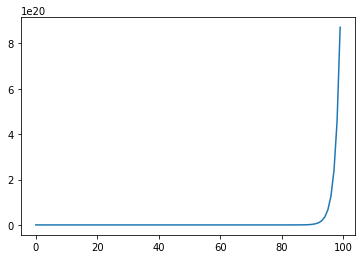

In [163]:
plt.plot(cost)